In [1]:
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import load_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence

from matplotlib import pyplot as plt
from kerasutils import plot_training_data, describe_model

from lstm_textgen import TextToTrainingData


/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
print(os.getcwd())

/home/ubuntu/jdm/cnn/Transform-CNNs


In [3]:
# load ascii text and covert to lowercase
#path = '../../data/'
#filename = "ml.txt"
path = './'
# No replies in this one
filename = '@dril.2018-04-22.txt'
raw_text = open(path+filename).read()
raw_text = raw_text.lower()

print(len(raw_text))

239840


In [4]:
text_to_train = TextToTrainingData(raw_text)
print("Total Characters: ", text_to_train.n_chars)
print("Total Vocab: ", text_to_train.n_vocab)
print(text_to_train.chars)

Total Characters:  239840
Total Vocab:  77
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '°', 'ê', '̶', '—', '…', '™', '▀', '▄', '█', '▐', '░', '⸻', '》']


In [5]:
seq_length=30
X,y = text_to_train.get_training_data(seq_length=seq_length)

print("Total patterns: ", len(X))
print(X.shape)
print(y.shape)
input_shape = X[0,:,:].shape
print('Input shape: {0}'.format(input_shape))

Total patterns:  239810
(239810, 30, 1)
(239810, 77)
Input shape: (30, 1)


In [14]:
# define the LSTM model
n_vocab = text_to_train.n_vocab

model = Sequential()
model.add(LSTM(n_vocab*4, input_shape=input_shape, 
          return_sequences=True, activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(n_vocab*2, activation='relu'))
model.add(Dropout(0.25))
#model.add(Dense(n_vocab*2))
#model.add(Activation('relu'))
#model.add(Dropout(0.25))
model.add(Dense(n_vocab, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
#print(X.shape)
#print(y.shape)
nsubset = 50000

x_short = X[0:nsubset,:,:]
y_short = y[0:nsubset,:]
# x_short = X 
# y_short = y

#x_train, x_test, y_train, y_test = train_test_split(x_short, y_short, test_size=0.5)
x_train = X[0:(nsubset),:,:]
y_train = y[0:(nsubset),:]
x_test = X[nsubset:int(1.1*nsubset),:,:]
y_test = y[nsubset:int(1.1*nsubset),:]


print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(50000, 30, 1)
(5000, 30, 1)
(50000, 77)
(5000, 77)


In [89]:
callbacks_list = None

In [93]:
# define the checkpoint
filepath=filename+".{epoch:02d}-{loss:.4f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


In [94]:
batch_size=280
n_epochs=10

h=model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, 
            validation_data=(x_test, y_test),
            callbacks=callbacks_list)

Train on 50000 samples, validate on 5000 samples
Epoch 1/10
50000/50000 [==============================] - 21s 420us/step - loss: 2.1996 - acc: 0.3506 - val_loss: 2.5853 - val_acc: 0.2886

Epoch 00001: val_loss improved from inf to 2.58533, saving model to @dril.2018-04-22.txt.01-2.1996.hdf5
Epoch 2/10
50000/50000 [==============================] - 21s 418us/step - loss: 2.1998 - acc: 0.3534 - val_loss: 2.5833 - val_acc: 0.2906

Epoch 00002: val_loss improved from 2.58533 to 2.58327, saving model to @dril.2018-04-22.txt.02-2.1998.hdf5
Epoch 3/10
50000/50000 [==============================] - 21s 418us/step - loss: 2.1820 - acc: 0.3557 - val_loss: 2.5852 - val_acc: 0.2870

Epoch 00003: val_loss did not improve
Epoch 4/10
50000/50000 [==============================] - 21s 418us/step - loss: 2.1707 - acc: 0.3576 - val_loss: 2.5922 - val_acc: 0.2914

Epoch 00004: val_loss did not improve
Epoch 5/10
50000/50000 [==============================] - 21s 417us/step - loss: 2.1693 - acc: 0.3581 -

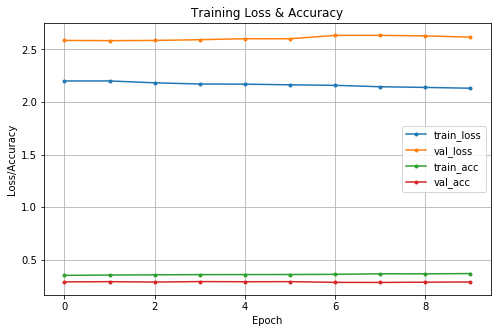

In [95]:
plot_training_data(h)

In [16]:
model.layers[1].rate = 0.4
model.layers[3].rate = 0.4

In [ ]:
prompt = text_to_train.prompt_input('this that or the other ', input_shape[0])
text = text_to_train.generate_text(model=model, 
                                   generated_seq_length=280, 
                                   prompt=prompt)
print(text)
#print(len(text))

In [87]:
inp = 'blah'

while len(inp) > 0:
    inp = input('?')
    if len(inp) > input_shape[0]:
        inp = inp[-input_shape[0]:]
    prompt = text_to_train.prompt_input(inp, input_shape[0])
    text = text_to_train.generate_text(model=model, 
                                       generated_seq_length=180, 
                                       prompt=prompt)
    print(text)

?one two three four five six seven eight nine
four five six seven eight nine morsu bse sans forp tean anl toin !out im poee hot "tou aare to aos a port on wou ko the paileon hooosd up kint hiws teank th hal ing co aos hempine bes ials tef 900 is am aes ih 
?there's an ass and a butt to be had
's an ass and a butt to be hade sw yoa eade ohe anm deck to tare at aee the warh oe the ctdst
ofkd  oereas clwm woat a caoc nt "yori therey crtp thek lifengals weat te fnmeinn to yeerenn toe letiing lo ius homi


KeyboardInterrupt: 

In [175]:
describe_model(model)

Layer 0: <class 'keras.layers.recurrent.LSTM'>
    input=(None, 30, 1)
    output=(None, 30, 308)
    act=<function tanh at 0x7f330a7188c8>
Layer 1: <class 'keras.layers.core.Dropout'>
    input=(None, 30, 308)
    output=(None, 30, 308)
    rate=0.15
Layer 2: <class 'keras.layers.recurrent.LSTM'>
    input=(None, 30, 308)
    output=(None, 154)
    act=<function tanh at 0x7f330a7188c8>
Layer 3: <class 'keras.layers.core.Dropout'>
    input=(None, 154)
    output=(None, 154)
    rate=0.15
Layer 4: <class 'keras.layers.core.Dense'>
    input=(None, 154)
    output=(None, 77)
    act=<function softmax at 0x7f330a718598>


In [13]:
describe_model(model)

Layer 0: <class 'keras.layers.recurrent.LSTM'>
    input=(None, 30, 1)
    output=(None, 30, 308)
    act=<function relu at 0x7f394bb4cea0>
Layer 1: <class 'keras.layers.core.Dropout'>
    input=(None, 30, 308)
    output=(None, 30, 308)
    rate=0.2
Layer 2: <class 'keras.layers.recurrent.LSTM'>
    input=(None, 30, 308)
    output=(None, 154)
    act=<function relu at 0x7f394bb4cea0>
Layer 3: <class 'keras.layers.core.Dropout'>
    input=(None, 154)
    output=(None, 154)
    rate=0.2
Layer 4: <class 'keras.layers.core.Dense'>
    input=(None, 154)
    output=(None, 77)
    act=<function softmax at 0x7f394bb4cbf8>


In [176]:
# Evaluate TEST model class prediction accuracy
print("[INFO] Evaluating network...")
predictions = model.predict(x_test, batch_size=batch_size)
target_names = chars
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=target_names))

[INFO] Evaluating network...
             precision    recall  f1-score   support

          
       0.62      0.53      0.57       529
                  0.70      0.85      0.77      7497
          !       0.82      0.39      0.53        36
          "       0.47      0.50      0.49       253
          #       0.62      0.53      0.57        15
          $       0.60      0.25      0.35        12
          %       0.00      0.00      0.00         4
          &       0.33      0.11      0.16        19
          '       0.79      0.28      0.41        40
          (       0.67      0.13      0.22        30
          )       1.00      0.14      0.25        35
          *       1.00      0.50      0.67         2
          +       0.52      0.30      0.38       225
          ,       0.35      0.15      0.21        39
          -       0.75      0.47      0.58       374
          .       0.98      0.95      0.96       226
          /       0.58      0.76      0.66       105
          0     

/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 67, does not match size of target_names, 77
  .format(len(labels), len(target_names))
/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [150]:
# Evaluate TRAIN model class prediction accuracy
print("[INFO] Evaluating network...")
predictions = model.predict(x_train, batch_size=batch_size)
target_names = chars
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=target_names))

[INFO] Evaluating network...
             precision    recall  f1-score   support

          
       0.79      0.48      0.59      1196
                  0.68      0.87      0.76     16696
          !       0.83      0.57      0.68        70
          "       0.73      0.44      0.55       626
          #       0.91      0.28      0.43        36
          $       1.00      0.20      0.33        35
          %       0.67      0.15      0.25        13
          &       0.58      0.18      0.28        38
          '       0.92      0.15      0.26        72
          (       0.60      0.06      0.12        47
          )       0.85      0.19      0.31        58
          *       0.00      0.00      0.00         2
          +       0.77      0.24      0.37       478
          ,       0.82      0.16      0.26        90
          -       0.83      0.45      0.59       833
          .       0.99      0.96      0.98       521
          /       0.65      0.77      0.71       275
          0     

/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 73, does not match size of target_names, 77
  .format(len(labels), len(target_names))
/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
# load the network weights for the final model
#weights_file = "ml.txt.10-2.8160.hdf5"
weights_file = "@dril.2018-04-22.txt.16-0.2807.hdf5"
#model.load_weights(weights_file)
model = load_model(weights_file)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [134]:
print(255*x_train[100,:,:])
print(255*x_train[101,:,:])

[[142.4025974 ]
 [125.84415584]
 [165.58441558]
 [172.20779221]
 [192.07792208]
 [185.45454545]
 [  3.31168831]
 [129.15584416]
 [205.32467532]
 [  3.31168831]
 [135.77922078]
 [182.14285714]
 [ 49.67532468]
 [  3.31168831]
 [139.09090909]
 [195.38961039]
 [152.33766234]
 [162.27272727]
 [  3.31168831]
 [152.33766234]
 [168.8961039 ]
 [  3.31168831]
 [125.84415584]
 [192.07792208]
 [185.45454545]
 [188.76623377]
 [152.33766234]
 [168.8961039 ]
 [  3.31168831]
 [175.51948052]]
[[125.84415584]
 [165.58441558]
 [172.20779221]
 [192.07792208]
 [185.45454545]
 [  3.31168831]
 [129.15584416]
 [205.32467532]
 [  3.31168831]
 [135.77922078]
 [182.14285714]
 [ 49.67532468]
 [  3.31168831]
 [139.09090909]
 [195.38961039]
 [152.33766234]
 [162.27272727]
 [  3.31168831]
 [152.33766234]
 [168.8961039 ]
 [  3.31168831]
 [125.84415584]
 [192.07792208]
 [185.45454545]
 [188.76623377]
 [152.33766234]
 [168.8961039 ]
 [  3.31168831]
 [175.51948052]
 [172.20779221]]
